확실한 spammer에 대한 정보를 가지기 위해서 (training에 사용할 데이터)

조건1 : reviewer Burstiness (RB) - focused on product
(한 제품에 일정 날에 리뷰를 많이남긴 리뷰어)

조건2 : reviewer who has a lot of reviews
(minimum리뷰수를 적절히 바꿔가면서 리뷰가 많은 리뷰어 찾기)

조건3 : 상호명(아뜨랑스, 고고싱, 스타일난다(난다))를 직접적으로 언급한 리뷰

조건4 : 평균 rScore가 5에 가까운 리뷰어

조건5 : 한 제품에 여러번 리뷰를 남긴 리뷰어

5개 모두 적용되는 리뷰어

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from konlpy.utils import pprint 

# gogosing dataset

In [22]:
#gogosing
common_front = '../dataset/go_0715/gogosing_' 
common_back = '.json'

def get_file(file_num):   
    file_path = common_front + str(file_num) + common_back
    json_data = open(file_path).read()
    data = json.loads(json_data)
    df_data = pd.DataFrame(data)
    return df_data

# 74번 파일이 에러가 나서 제외함
def concat_file(file_num):
    start_file = pd.DataFrame(get_file(1))
    for i in range(2,file_num+1):
        if( i == 74):
            continue
        df_tmp = pd.DataFrame(get_file(i))
        start_file = pd.concat([start_file, df_tmp])
    start_file = start_file.reset_index(drop=True)
    return start_file

go_data = concat_file(156)

In [26]:
print("total amount of gogosing data(reviews) : " + str(go_data.shape[0]))

total amount of gogosing data(reviews) : 772829


attrangs에는 네이버페이 구매자가 존재하지 않음

# original rScore distribution in attrangs

In [27]:
original_rscore = go_data['rScore'].value_counts()
original_rscore

5.0    700708
4.0     46769
3.0     18178
2.0      4563
1.0      2611
Name: rScore, dtype: int64

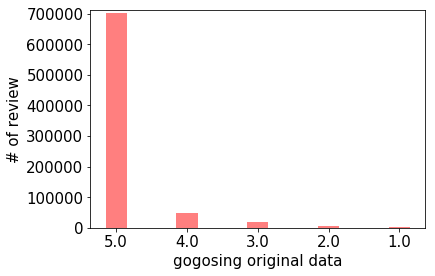

ratio btw 5.0 and 4.0 : 14.982317347
ratio btw 5.0 and 3.0 : 38.5470348773
ratio btw 5.0 and 2.0 : 153.563006794
ratio btw 5.0 and 1.0 : 268.36767522
the number of 5.0 reviews : 700708
the number of 4.0 reviews : 46769
the number of 3.0 reviews : 18178
the number of 2.0 reviews : 4563
the number of 1.0 reviews : 2611


In [28]:
score = ('5.0', '4.0', '3.0', '2.0', '1.0')
number_of_reviews = [original_rscore[5.0],
                    original_rscore[4.0],
                    original_rscore[3.0],
                    original_rscore[2.0],
                    original_rscore[1.0]
                    ]

plt.bar(score, number_of_reviews, color=['red'],
        width=0.3, alpha=0.5)
plt.xticks(score, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('# of review', fontsize=15)
plt.rcParams["figure.figsize"] = (6,4)
plt.xlabel('gogosing original data', fontsize=15)
ax = plt.gca()
ax.set_ylim([0.0, original_rscore[5.0] + 10000])
plt.show()

print ("ratio btw 5.0 and 4.0 : " + str(float(original_rscore[5.0])/original_rscore[4.0]))
print ("ratio btw 5.0 and 3.0 : " + str(float(original_rscore[5.0])/original_rscore[3.0]))
print ("ratio btw 5.0 and 2.0 : " + str(float(original_rscore[5.0])/original_rscore[2.0]))
print ("ratio btw 5.0 and 1.0 : " + str(float(original_rscore[5.0])/original_rscore[1.0]))

print ("the number of 5.0 reviews : " + str(original_rscore[5.0]))
print ("the number of 4.0 reviews : " + str(original_rscore[4.0]))
print ("the number of 3.0 reviews : " + str(original_rscore[3.0]))
print ("the number of 2.0 reviews : " + str(original_rscore[2.0]))
print ("the number of 1.0 reviews : " + str(original_rscore[1.0]))
    

In [30]:
go_unique_pid = go_data.pID.unique()
print("the number of unique pid in gogosing : " + str(len(go_unique_pid)))
go_unique_rDate =go_data.rDate.unique()
print("the number of unique rDate in gogosing : " + str(len(go_unique_rDate)))
go_unique_cid = go_data.cId.unique()
print("the number of unique cid in gogosing : " + str(len(go_unique_cid)))

the number of unique pid in gogosing : 25602
the number of unique rDate in gogosing : 3352
the number of unique cid in gogosing : 138650


# condition 1 : reviewer Burstiness (RB) - focused on product

(한 제품에 일정 날에 리뷰를 많이남긴 리뷰어)

In [31]:
def burst_in_product(min_count, dataframe):
    condition1 = []
    product_burst = pd.DataFrame({'count' : dataframe.groupby( [ "pID", "rDate", "cId"] ).size()}).reset_index()
    suspicious_reviewers = (product_burst[product_burst['count'] >= min_count])['cId']
    for reviewer in suspicious_reviewers:
        condition1.append(reviewer)
    return remove_duplicate_from_list(condition1)
    

In [32]:
def remove_duplicate_from_list(input_list):
    tmp_set = set(input_list)
    result = list(tmp_set)
    return result

# condition 2 : reviewer who has a lot of reviews
(minimum리뷰수를 적절히 바꿔가면서 리뷰가 많은 리뷰어 찾기)

In [33]:
def find_reviewer_who_has_many_reviews(min_review, dataframe):
    condition2 = []
    reviewer_and_reviews = dataframe['cId'].value_counts()
    suspicious_reviewers = reviewer_and_reviews[reviewer_and_reviews >= min_review].index
    for reviewer in suspicious_reviewers:
        condition2.append(reviewer)
    return condition2

#.encode('ascii','ignore')

# condition 3 : 상호명(아뜨랑스, 고고싱, 스타일난다(난다))를 직접적으로 언급한 리뷰어

In [34]:
def reviewer_who_directly_write_sitename(min_count, dataframe):
    condition3 = [] 
    reviewer_who_write_sitename = dataframe[dataframe['desc'].str.contains(u"고고싱")]
    reviewer_and_reviews = reviewer_who_write_sitename['cId'].value_counts()
    suspicious_reviewers = reviewer_and_reviews[reviewer_and_reviews >= min_count].index
    for reviewer in suspicious_reviewers:
        condition3.append(reviewer)
        
    return condition3

# condition4 : 평균 rScore가 5에 가까운 리뷰어



In [35]:
def reviewer_who_has_high_rscore(min_rscore, dataframe):
    condition4 = [] 
    mean_rscore = dataframe.groupby(dataframe.cId).mean()['rScore']
    suspicious_reviewers = mean_rscore[mean_rscore >= min_rscore].index
    for reviewer in suspicious_reviewers:
        condition4.append(reviewer)
        
    return condition4

In [36]:
def intersect(lst1, lst2):
    return list(set(lst1) & set(lst2))

#spam_reviewers = (intersect(intersect(intersect(condition3, condition4), condition2), condition1))
#pprint(spam_reviewers)

# condition 5 : reviewer who has many reviews in A product over all time

In [37]:
def reviewer_who_has_many_reviews_in_a_product(min_count, dataframe):
    condition5 = []
    product_burst = pd.DataFrame({'count' : dataframe.groupby( [ "pID", "cId"] ).size()}).reset_index()
    suspicious_reviewers = (product_burst[product_burst['count'] >= min_count])['cId']
    for reviewer in suspicious_reviewers:
        condition5.append(reviewer)
    
    return remove_duplicate_from_list(condition5)

#reviewer_who_has_many_reviews_in_a_product(7)

앞자리만 같은 리뷰어는.. 생각해줘야함!!!

# 값만 주면 한번에 실행하는 함수

# reviewer_who_satisfy_some_condition - intersect ver.

spammer cId리스트 반환

In [52]:
'''
각 bool 파라미터는 각 조건의 포함여부를 나타내며 실험32의 경우 모든 조건을 보므로 다 1임
cond1 : 한 제품 & 특정 날짜에 cond1개 초과로 남긴 리뷰어
cond2 : cond2개 초과의 리뷰를 가진 리뷰어
cond3 : 상호명 언급을 cond3번 초과한 리뷰어
cond4 : 평점 cond4초과 리뷰어
cond5 : 한제품에 cond5개 초과로 리뷰남긴 리뷰어 추가하기
'''
def reviewer_who_satisfy_some_condition(dataframe, cond1_bool, cond2_bool, cond3_bool, cond4_bool, cond5_bool,
                                        cond1, cond2, cond3, cond4, cond5):
    
    unique_cid = dataframe.cId.unique()
    #condition1
    if(cond1_bool == 1):
        reviewer1 = burst_in_product(cond1, dataframe)
    else:
        reviewer1 = unique_cid
    
    #condition2
    if(cond2_bool == 1):
        reviewer2 = find_reviewer_who_has_many_reviews(cond2, dataframe)
    else:
        reviewer2 = unique_cid
        
    #condition3
    if(cond3_bool == 1):
        reviewer3 = reviewer_who_directly_write_sitename(cond3, dataframe)
    else:
        reviewer3 = unique_cid
    
    #condition4
    if(cond4_bool == 1):
        reviewer4 = reviewer_who_has_high_rscore(cond4, dataframe)
    else:
        reviewer4 = unique_cid
        
    #condition5
    if(cond5_bool == 1):
        reviewer5 = reviewer_who_has_many_reviews_in_a_product(cond5, dataframe)
    else:
        reviewer5 = unique_cid
        
    spam_reviewers = intersect(intersect(intersect(intersect(reviewer1, reviewer2), reviewer3), reviewer4), reviewer5)
    
    #네이버 페이 구매자는 제외
    if(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790' in spam_reviewers):
        spam_reviewers.remove(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790')
    
    except_spam_in_gogosing = dataframe[~dataframe.cId.isin(spam_reviewers)]
    print("<intersect condition>")
    print("cond1 =" + str(cond1) + ", cond2 =" + str(cond2) + ", cond3 =" + str(cond3) + ", cond4 =" + str(cond4) + ", cond5 =" + str(cond5))
    print("the number of spam_reviewers : " + str(len(spam_reviewers)))
    print("suspicious spammers : "),
    print(spam_reviewers)
    print("the number of non spam reviewers : " + str(len(except_spam_in_gogosing.cId.unique())))
    rscore = except_spam_in_gogosing['rScore'].value_counts()
      
    #print("except spam in gogosing : " )
    #print(except_spam_in_gogosing)

    #어떤 평점의 리뷰가 전체 사라질 경우를 방지하기 위함
    if(not(5.0 in rscore.index)):
        add_row = pd.Series([1], index=[5.0])
        rscore = rscore.add(add_row)
    if(not(4.0 in rscore.index)):
        add_row = pd.Series([1], index=[4.0])
        rscore = rscore.add(add_row)
    if(not(3.0 in rscore.index)):
        add_row = pd.Series([1], index=[3.0])
        rscore = rscore.add(add_row)
    if(not(2.0 in rscore.index)):
        add_row = pd.Series([1], index=[2.0])
        rscore = rscore.add(add_row)
    if(not(1.0 in rscore.index)):
        add_row = pd.Series([1], index=[1.0])
        rscore = rscore.add(add_row)
        
    print("\n")
    print("rscore : ")
    print(rscore)        
    
    print ("ratio btw 5.0 and 4.0 : " + str(float(rscore[5.0])/float(rscore[4.0])))
    print ("ratio btw 5.0 and 3.0 : " + str(float(rscore[5.0])/float(rscore[3.0])))
    print ("ratio btw 5.0 and 2.0 : " + str(float(rscore[5.0])/float(rscore[2.0])))
    print ("ratio btw 5.0 and 1.0 : " + str(float(rscore[5.0])/float(rscore[1.0])))
    
    print ("the number of 5.0 reviews : " + str(rscore[5.0]))
    print ("the number of 4.0 reviews : " + str(rscore[4.0]))
    print ("the number of 3.0 reviews : " + str(rscore[3.0]))
    print ("the number of 2.0 reviews : " + str(rscore[2.0]))
    print ("the number of 1.0 reviews : " + str(rscore[1.0]))
                    
    score = ('5.0', '4.0', '3.0', '2.0', '1.0')
    number_of_reviews = [rscore[5.0],
                     rscore[4.0],
                     rscore[3.0],
                     rscore[2.0],
                     rscore[1.0]]

    plt.bar(score, number_of_reviews, color=['red'],
        width=0.3, alpha=0.5)
    plt.xticks(score, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('# of review', fontsize=15)
    plt.rcParams["figure.figsize"] = (6,4)
    plt.xlabel('rScore', fontsize=15)
    ax = plt.gca()
    ax.set_ylim([0.0, except_spam_in_gogosing.shape[0]+500])
    plt.show()
    print("\n\n")
    return spam_reviewers

# reviewer_who_satisfy_some_condition - union ver.

non spammer들의 cId리스트 반환

In [56]:
def reviewer_who_satisfy_some_condition_union(dataframe, cond1_bool, cond2_bool, cond3_bool, cond4_bool, cond5_bool,
                                        cond1, cond2, cond3, cond4, cond5):
    
     #condition1
    if(cond1_bool == 1):
        reviewer1 = burst_in_product(cond1, dataframe)
    else:
        reviewer1 = []
    
    #condition2
    if(cond2_bool == 1):
        reviewer2 = find_reviewer_who_has_many_reviews(cond2, dataframe)
    else:
        reviewer2 = []
        
    #condition3
    if(cond3_bool == 1):
        reviewer3 = reviewer_who_directly_write_sitename(cond3, dataframe)
    else:
        reviewer3 = []
    
    #condition4
    if(cond4_bool == 1):
        reviewer4 = reviewer_who_has_high_rscore(cond4, dataframe)
    else:
        reviewer4 = []
        
    #condition5
    if(cond5_bool == 1):
        reviewer5 = reviewer_who_has_many_reviews_in_a_product(cond5, dataframe)
    else:
        reviewer5 = []  
        
    spam_reviewers = remove_duplicate_from_list(reviewer1 + reviewer2 + reviewer3 + reviewer4 + reviewer5)
    
    
    #네이버 페이 구매자는 스패머에서 일단 제외
    if(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790' in spam_reviewers):
        spam_reviewers.remove(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790')
    
    except_spam_in_gogosing = dataframe[~dataframe.cId.isin(spam_reviewers)]
    print("total number of suspicious spam reviewers : " + str(len(spam_reviewers)))

    print("total number of expected non-spam reviewers : " + str(len(except_spam_in_gogosing.cId.unique()))) 
    
    print("<union condition>")
    print("cond1 =" + str(cond1) + ", cond2 =" + str(cond2) + ", cond3 =" + str(cond3) + ", cond4 =" + str(cond4) + ", cond5 =" + str(cond5))
    
    rscore = except_spam_in_gogosing['rScore'].value_counts()
     

    if(not(5.0 in rscore.index)):
        add_row = pd.Series([1], index=[5.0])
        rscore = rscore.add(add_row)
    if(not(4.0 in rscore.index)):
        add_row = pd.Series([1], index=[4.0])
        rscore = rscore.add(add_row)
    if(not(3.0 in rscore.index)):
        add_row = pd.Series([1], index=[3.0])
        rscore = rscore.add(add_row)
    if(not(2.0 in rscore.index)):
        add_row = pd.Series([1], index=[2.0])
        rscore = rscore.add(add_row)
    if(not(1.0 in rscore.index)):
        add_row = pd.Series([1], index=[1.0])
        rscore = rscore.add(add_row)  
    
    print ("ratio btw 5.0 and 4.0 : " + str(float(rscore[5.0])/float(rscore[4.0])))
    print ("ratio btw 5.0 and 3.0 : " + str(float(rscore[5.0])/float(rscore[3.0])))
    print ("ratio btw 5.0 and 2.0 : " + str(float(rscore[5.0])/float(rscore[2.0])))
    print ("ratio btw 5.0 and 1.0 : " + str(float(rscore[5.0])/float(rscore[1.0])))
    

    print ("the number of 5.0 reviews : " + str(rscore[5.0]))
    print ("the number of 4.0 reviews : " + str(rscore[4.0]))
    print ("the number of 3.0 reviews : " + str(rscore[3.0]))
    print ("the number of 2.0 reviews : " + str(rscore[2.0]))
    print ("the number of 1.0 reviews : " + str(rscore[1.0]))
    
                    
    score = ('5.0', '4.0', '3.0', '2.0', '1.0')
    number_of_reviews = [rscore[5.0],
                     rscore[4.0],
                     rscore[3.0],
                     rscore[2.0],
                     rscore[1.0]]

    plt.bar(score, number_of_reviews, color=['red'],
        width=0.3, alpha=0.5)
    plt.xticks(score, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('# of review', fontsize=15)
    plt.rcParams["figure.figsize"] = (6,4)
    plt.xlabel('rScore', fontsize=15)
    ax = plt.gca()
    ax.set_ylim([0.0, except_spam_in_gogosing.shape[0]+1000])
    plt.show()
    print("\n\n")
    
    return except_spam_in_gogosing.cId.unique()

# intersect



<intersect condition>
cond1 =3, cond2 =50, cond3 =10, cond4 =4.95, cond5 =2
the number of spam_reviewers : 26
suspicious spammers :  [u'asdfg18**', u'ghkal04**', u'rladmswl9708**', u'leeliast**', u'rhdms10**', u'sally70**', u'm0928hy**', u'yeji04**', u'sejin1**', u'wlgml13**', u'yjyim**', u'hooming**', u'sy2004**', u'ik35**', u'sosososo**', u'yeon33**', u'loveheart77**', u'wjswldms0**', u'ch**', u'jy03**', u'seoa40**', u'altnr**', u'acua**', u'wertyuio9**', u'chihn19**', u'dekuu12**']
the number of non spam reviewers : 138624


rscore : 
5.0    697487
4.0     46753
3.0     18167
2.0      4561
1.0      2610
Name: rScore, dtype: int64
ratio btw 5.0 and 4.0 : 14.9185506812
ratio btw 5.0 and 3.0 : 38.3930753564
ratio btw 5.0 and 2.0 : 152.924139443
ratio btw 5.0 and 1.0 : 267.236398467
the number of 5.0 reviews : 697487
the number of 4.0 reviews : 46753
the number of 3.0 reviews : 18167
the number of 2.0 reviews : 4561
the number of 1.0 reviews : 2610


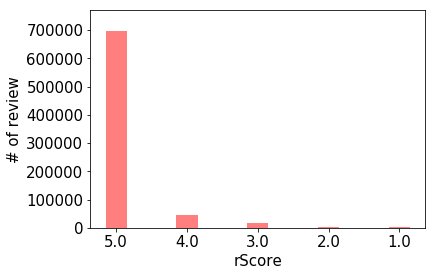

[u'asdfg18**',
 u'ghkal04**',
 u'rladmswl9708**',
 u'leeliast**',
 u'rhdms10**',
 u'sally70**',
 u'm0928hy**',
 u'yeji04**',
 u'sejin1**',
 u'wlgml13**',
 u'yjyim**',
 u'hooming**',
 u'sy2004**',
 u'ik35**',
 u'sosososo**',
 u'yeon33**',
 u'loveheart77**',
 u'wjswldms0**',
 u'ch**',
 u'jy03**',
 u'seoa40**',
 u'altnr**',
 u'acua**',
 u'wertyuio9**',
 u'chihn19**',
 u'dekuu12**']

In [54]:
reviewer_who_satisfy_some_condition(go_data, 1, 1, 1, 1, 1, 3, 50, 10, 4.95, 2)

<intersect condition>
cond1 =3, cond2 =50, cond3 =10, cond4 =4.96, cond5 =3
the number of spam_reviewers : 24
suspicious spammers :  [u'ghkal04**', u'rladmswl9708**', u'leeliast**', u'rhdms10**', u'sally70**', u'm0928hy**', u'yeji04**', u'sejin1**', u'wlgml13**', u'asdfg18**', u'hooming**', u'sy2004**', u'ik35**', u'sosososo**', u'yeon33**', u'loveheart77**', u'wjswldms0**', u'ch**', u'jy03**', u'seoa40**', u'altnr**', u'acua**', u'chihn19**', u'dekuu12**']
the number of non spam reviewers : 138626


rscore : 
5.0    697837
4.0     46758
3.0     18170
2.0      4563
1.0      2610
Name: rScore, dtype: int64
ratio btw 5.0 and 4.0 : 14.9244407374
ratio btw 5.0 and 3.0 : 38.4059988993
ratio btw 5.0 and 2.0 : 152.933815472
ratio btw 5.0 and 1.0 : 267.370498084
the number of 5.0 reviews : 697837
the number of 4.0 reviews : 46758
the number of 3.0 reviews : 18170
the number of 2.0 reviews : 4563
the number of 1.0 reviews : 2610


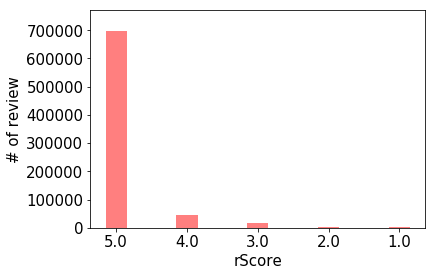

[u'ghkal04**',
 u'rladmswl9708**',
 u'leeliast**',
 u'rhdms10**',
 u'sally70**',
 u'm0928hy**',
 u'yeji04**',
 u'sejin1**',
 u'wlgml13**',
 u'asdfg18**',
 u'hooming**',
 u'sy2004**',
 u'ik35**',
 u'sosososo**',
 u'yeon33**',
 u'loveheart77**',
 u'wjswldms0**',
 u'ch**',
 u'jy03**',
 u'seoa40**',
 u'altnr**',
 u'acua**',
 u'chihn19**',
 u'dekuu12**']

In [58]:
reviewer_who_satisfy_some_condition(go_data, 1, 1, 1, 1, 1, 3, 50, 10, 4.96, 3)

<intersect condition>
cond1 =3, cond2 =50, cond3 =2, cond4 =4.96, cond5 =3
the number of spam_reviewers : 46
suspicious spammers :  [u'ghkal04**', u'rladmswl9708**', u'wldwldg**', u'leeliast**', u'rhdms10**', u'sally70**', u'm0928hy**', u'yeji04**', u'gloryn**', u'sestt**', u'dorosy11**', u'wlgml13**', u'rhdecyli**', u'phr9101**', u'asdfg18**', u'diqkdldiqk**', u'hooming**', u'sy2004**', u'qpqlgi**', u'tmfrl123**', u'jhw20**', u'sejin1**', u'ngt**', u'sosososo**', u'yeon33**', u'chdms03**', u'kimminji**', u'loveheart77**', u'qapl44**', u'wjswldms0**', u'ch**', u'jy03**', u'seoa40**', u'altnr**', u'acua**', u'ik35**', u'ekdmsdl07**', u'redgirl4**', u'dev**', u'ans56**', u'chihn19**', u'syndrome12**', u'sjj44**', u'dekuu12**', u'jsh**', u'gmlwls20**']
the number of non spam reviewers : 138604


rscore : 
5.0    696081
4.0     46753
3.0     18167
2.0      4563
1.0      2610
Name: rScore, dtype: int64
ratio btw 5.0 and 4.0 : 14.8884777447
ratio btw 5.0 and 3.0 : 38.3156822811
ratio btw 5.0

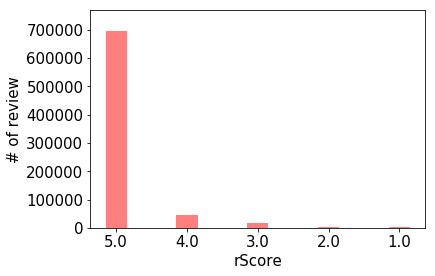

[u'ghkal04**',
 u'rladmswl9708**',
 u'wldwldg**',
 u'leeliast**',
 u'rhdms10**',
 u'sally70**',
 u'm0928hy**',
 u'yeji04**',
 u'gloryn**',
 u'sestt**',
 u'dorosy11**',
 u'wlgml13**',
 u'rhdecyli**',
 u'phr9101**',
 u'asdfg18**',
 u'diqkdldiqk**',
 u'hooming**',
 u'sy2004**',
 u'qpqlgi**',
 u'tmfrl123**',
 u'jhw20**',
 u'sejin1**',
 u'ngt**',
 u'sosososo**',
 u'yeon33**',
 u'chdms03**',
 u'kimminji**',
 u'loveheart77**',
 u'qapl44**',
 u'wjswldms0**',
 u'ch**',
 u'jy03**',
 u'seoa40**',
 u'altnr**',
 u'acua**',
 u'ik35**',
 u'ekdmsdl07**',
 u'redgirl4**',
 u'dev**',
 u'ans56**',
 u'chihn19**',
 u'syndrome12**',
 u'sjj44**',
 u'dekuu12**',
 u'jsh**',
 u'gmlwls20**']

In [60]:
reviewer_who_satisfy_some_condition(go_data, 1, 1, 1, 1, 1, 3, 50, 2, 4.96, 3)

# union

total number of suspicious spam reviewers : 112031
total number of expected non-spam reviewers : 26619
<union condition>
cond1 =3, cond2 =50, cond3 =10, cond4 =4.95, cond5 =2
ratio btw 5.0 and 4.0 : 4.99350310153
ratio btw 5.0 and 3.0 : 13.7471687938
ratio btw 5.0 and 2.0 : 54.1995038979
ratio btw 5.0 and 1.0 : 88.6158748552
the number of 5.0 reviews : 152951
the number of 4.0 reviews : 30630
the number of 3.0 reviews : 11126
the number of 2.0 reviews : 2822
the number of 1.0 reviews : 1726


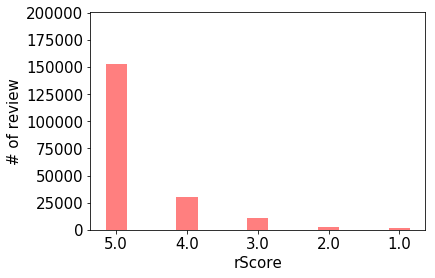

array([u'geeuns**', u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790',
       u'achvi**', ..., u'loveeng**', u'qufwnsg**', u'abc06**'],
      dtype=object)

In [57]:
reviewer_who_satisfy_some_condition_union(go_data, 1, 1, 1, 1, 1, 3, 50, 10, 4.95, 2)

total number of suspicious spam reviewers : 107046
total number of expected non-spam reviewers : 31604
<union condition>
cond1 =3, cond2 =50, cond3 =10, cond4 =4.96, cond5 =3
ratio btw 5.0 and 4.0 : 5.28002892552
ratio btw 5.0 and 3.0 : 13.9996694215
ratio btw 5.0 and 2.0 : 55.4596647459
ratio btw 5.0 and 1.0 : 93.9418811003
the number of 5.0 reviews : 211745
the number of 4.0 reviews : 40103
the number of 3.0 reviews : 15125
the number of 2.0 reviews : 3818
the number of 1.0 reviews : 2254


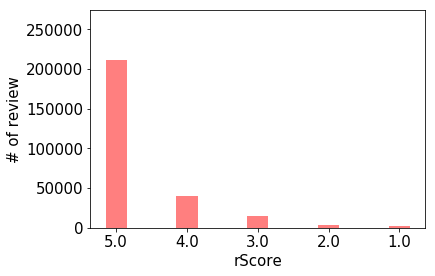

array([u'geeuns**', u'mdk67**', u'ekdus1**', ..., u'qufwnsg**',
       u'abc06**', u'skyqhd**'], dtype=object)

In [59]:
reviewer_who_satisfy_some_condition_union(go_data, 1, 1, 1, 1, 1, 3, 50, 10, 4.96, 3)

total number of suspicious spam reviewers : 112289
total number of expected non-spam reviewers : 26361
<union condition>
cond1 =3, cond2 =50, cond3 =2, cond4 =4.96, cond5 =3
ratio btw 5.0 and 4.0 : 4.90415314731
ratio btw 5.0 and 3.0 : 12.9295124038
ratio btw 5.0 and 2.0 : 50.4998329435
ratio btw 5.0 and 1.0 : 84.4391061453
the number of 5.0 reviews : 151146
the number of 4.0 reviews : 30820
the number of 3.0 reviews : 11690
the number of 2.0 reviews : 2993
the number of 1.0 reviews : 1790


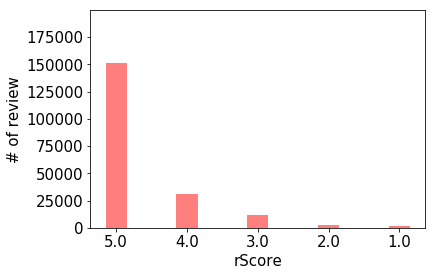

array([u'geeuns**', u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790',
       u'achvi**', ..., u'loveeng**', u'abc06**', u'skyqhd**'],
      dtype=object)

In [61]:
reviewer_who_satisfy_some_condition_union(go_data, 1, 1, 1, 1, 1, 3, 50, 2, 4.96, 3)